## Introduction

This jupyter notebook project is related to this article 
https://www.sciencedirect.com/science/article/pii/S0927025622005316?dgcid=author

If you use this code for research purposes, you are kindly invited to cite the associated research article:
"Seifallah Fetni, Thinh Quy Duc Pham, Truong Vinh Hoang, Hoang Son Tran, Laurent Duchêne, Xuan-Van Tran, Anne Marie Habraken,
Capabilities of Auto-encoders and Principal Component Analysis of the reduction of microstructural images; Application on the acceleration of Phase-Field simulations, Computational Materials Science, Volume 216, 2023, 111820, ISSN 0927-0256, https://doi.org/10.1016/j.commatsci.2022.111820."

### Abstract

In this work, a data-driven framework based on Phase-Field simulations data is proposed to highlight the capabilities of neural networks to ensure accurate low dimensionality reduction of simulated microstructural images and to provide time-series analysis. The dataset was indeed constructed from high-fidelity Phase-Field simulations. Analyses demonstrated that the association of auto-encoder neural networks and principal component analyses leads to ensure efficient and significant dimensionality reduction: 1/196 of reduction ratio with more than 80% of accuracy. These findings give insight to apply analyses on data from the latent dimension. Application of Long Short Term Memory (LSTM) neural networks showed the possibility of making next frame predictions; that makes possible the acceleration of Phase-Field simulation without the need of high computing resources. We discussed the application of such a framework on various areas of research. Different methods are proposed from the conducted analyses, in order to ensure dimensionality reduction (auto-encoders, principal component analysis, Artificial Neural Networks) and time-series analysis (LSTM, Gated Recurrent Unit (GRU)).

### Keywrods

Phase field ; Spinodal decomposition ; LSTM ; GRU ; Auto-encoders ; PCA ; HPC

# Import

In [ ]:
import numpy as np    #https://numpy.org/doc/stable/license.html
import matplotlib.pyplot as plt #   #https://matplotlib.org/stable/users/project/license.html

import tensorflow as tf  #https://github.com/tensorflow/tensorflow/blob/master/LICENSE
from tensorflow import keras
from tensorflow.keras import layers

import io
import cv2  #https://opencv.org/license/
import imageio  #https://github.com/imageio/imageio/blob/master/LICENSE
#from ipywidgets import widgets, Layout, HBox
import matplotlib.colors as colors
from skimage.transform import resize  #https://github.com/scikit-image/skimage-media/blob/main/LICENSE
from skimage.color import rgb2gray

from keras.callbacks import EarlyStopping #https://github.com/keras-team/keras/blob/master/LICENSE
import os
from sklearn.preprocessing import MinMaxScaler  #https://github.com/scikit-learn/sklearn-docbuilder/blob/master/LICENSE
from numba import jit  # use to speed up python

# Functions

In [ ]:
import re
# https://stackoverflow.com/questions/4813061/non-alphanumeric-list-order-from-os-listdir/48030307#48030307
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(data, key=alphanum_key)

In [ ]:
# load all images from a givel folder
@jit
def load_images_from_folder(folder):
    images = []
    list=sorted_alphanumeric(os.listdir(folder))

    for filename in list:

        img = cv2.imread(os.path.join(folder,filename))  # if binary, cv2.imread(os.path.join(folder,filename),2)
        img=cv2.resize(img, (128,128))

        #If desired binary images in output
        #img=img[:,:,0]                #  uncomment (these 2 lines) if the desired output is  binary images (method 1 to make images binary )
        #img=img.reshape(128,128,1)    #  idm

        #img=rgb2gray(img)   #  method 2 to make images binary 
        #ret, img = cv2.threshold(img,127,255,cv2.THRESH_BINARY)  # uncomment if binary images

        if img is not None:

            images.append(img)

    return images

In [ ]:
# check if all elements of a list are equals or not :
def are_equal(list):
    Element= list[0]
    isEqual = True
    
    for item in list:
        if Element != item:
            isEqual = False
            break;      
    return isEqual

In [ ]:
# get dimensions of the data
@jit
def get_data_shape(input_dir) :
    
    data=[]
    # number of folders in current directory
    folders_number=len([name for name in os.listdir(input_dir) ])
    # get length of each sequence
    sub_directories = os.listdir(input_dir) 
    array_seq_len=[]

    for f in sub_directories:
        folder_list = os.listdir(os.path.join(input_dir, f))
        f_path=os.path.join(input_dir,f)
        seq_len=len([filename for filename in os.listdir(f_path) if os.path.isfile(os.path.join(f_path, filename))])
        array_seq_len.append(seq_len)
    # get image_size
    im = cv2.imread(os.path.join(f_path, os.listdir(f_path)[0]))

    #  check if all sequences have the same length
    if are_equal(array_seq_len):
        data_shape=np.array([folders_number, array_seq_len[0],im.shape[0],im.shape[1],im.shape[2]])
        return data_shape
    else:
        print('error, check your folders, at least one of them contains a different number of images') 

In [ ]:
@jit
def load_all_data(input_dir):

    data_shape = get_data_shape(input_dir) 
    #np.empty(shape=(data_shape[0],data_shape[1],data_shape[2],data_shape[3],data_shape[4] ))  
    #data=np.empty([data_shape[1],data_shape[2],data_shape[3],data_shape[4] ])  
    data=[]
    folders = os.listdir(input_dir)

    for f in folders:
        f_path=os.path.join(input_dir,f)
        folder_list = [filename for filename in os.listdir(f_path) if os.path.isfile(os.path.join(f_path, filename))]
        #print(folder_list)
        sequence= load_images_from_folder(os.path.join(input_dir, f))
        data.append(sequence)    
          
    data=np.asarray(data)    
    #data = data.reshape(data_shape[0],data_shape[1],...)
    #print('data imported, seq_number:= ',data.shape[0])
    #data = np.expand_dims(data, axis=-1)   #uncomment if binary
    return data

In [ ]:
def invert_transform(data,scaler):
    for i in range(data.shape[0]):   
        for j in range(data.shape[1]):
            x=data[i][j]
            x = x.reshape(len(x), 1)
            scaler = scaler.fit(x)  
            x_inverted=scaler.inverse_transform(x)
            x_inverted=np.squeeze(x_inverted, axis=1)
            data[i][j]=x_inverted
    return data

In [ ]:
# denoise reconstructed image#
def denoise_image(reco):
    import numpy as np
    import cv2
    from matplotlib import pyplot as plt
   
    plt.axis('off')
    show_image(reco)
    
    plt.savefig('reco',bbox_inches="tight",pad_inches=0)
    img= cv2.imread('reco.png')
    plt.close()
    dst = cv2.fastNlMeansDenoisingColored(img, None, 10, 10, 10, 7)

    dst =cv2.resize(dst,(128,128),interpolation= cv2.INTER_LINEAR)
    """
    # Plotting of source and destination image
    plt.subplot(121), show_image(img.astype('float32') / 255.0 - 0.5)
    plt.title("Before")

    plt.subplot(122), show_image(dst.astype('float32') / 255.0 - 0.5)
    plt.title("After")
    """
    reco_denoised=dst.astype('float32') / 255.0 - 0.5

    #print(reco_denoised.shape)
    #print(reco.min(), reco.max())
    #print(reco_denoised.min(), reco_denoised.max())
    return  reco_denoised

# Import data   (HPC strongly recommended)

In [ ]:
dataset=load_all_data('sim_data')  # load a dataset from a folder 'sim_data' (not from a single .npy file)

In [ ]:
dataset=np.load('dataset_4800_bin.npy')    # big memory needed , be sure your dataset doesn't exceed few GBs depending on your 

##  Save all-files names (number of samples + each simulation characteristics) in a list

In [ ]:
# save all file-names in a list ==> to use later for training RNN models
# uncomment if you load a dataset from a folder 'sim_data' 
"""
data_dir=os.path.join(os.getcwd(),'sim_data/')
sub_directories =sorted_alphanumeric(os.listdir(data_dir))
list_names=[]
for f in sub_directories:
    sequence_names=[]
    folder_list = sorted_alphanumeric(os.listdir(os.path.join(data_dir, f)))
    f_path=os.path.join(data_dir,f)
    for filename in sorted_alphanumeric(os.listdir(f_path)):    
        sequence_names.append(filename)

    list_names.append(sequence_names)
"""


"\ndata_dir=os.path.join(os.getcwd(),'sim_data/')\nsub_directories =sorted_alphanumeric(os.listdir(data_dir))\nlist_names=[]\nfor f in sub_directories:\n    sequence_names=[]\n    folder_list = sorted_alphanumeric(os.listdir(os.path.join(data_dir, f)))\n    f_path=os.path.join(data_dir,f)\n    for filename in sorted_alphanumeric(os.listdir(f_path)):    \n        sequence_names.append(filename)\n\n    list_names.append(sequence_names)\n"

## prepare data for encoder-decoder model

In [ ]:
encod_dataset=dataset.reshape(np.prod(dataset.shape[:2]),*dataset.shape[2:])
print(dataset.shape,encod_dataset.shape)
X=encod_dataset


(25, 100, 128, 128, 3) (2500, 128, 128, 3)


In [ ]:
X = X.astype('float32') / 255.0 - 0.5   # big memory needed to normalize data (should be run in HPC, expect relatively small datasets)

In [ ]:
print(X.max(), X.min())

0.49215686 -0.49607843


## show sample(s)

In [ ]:
import matplotlib.pyplot as plt
def show_image(img):
    plt.imshow(np.clip(img + 0.5, 0, 1))  # uncomment if RGB
    #plt.imshow(img) # if binary

In [ ]:
show_image(X[np.random.choice(range(len(X)), size=1)[0]])

In [ ]:
from sklearn.model_selection import train_test_split
# the use of random_state is to reproduce the same results at each time 
X_train, X_test = train_test_split(X, test_size=0.1, random_state=42) 

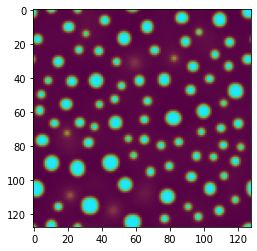

In [ ]:
show_image(X_test[np.random.choice(range(len(X_test)), size=1)[0]])

## for binary data

In [ ]:
scaler= MinMaxScaler(feature_range=(0,1))
scaler_ND = NDStandardScaler()
X_train_scaled= scaler_ND.fit_transform(X_train[:10000] )
X_test_scaled= scaler_ND.fit_transform(X_test[:] )
X_train_rescaled=scaler_ND.inverse_transform(X_train_scaled)
print(X_train.shape, X_train.min(),X_train.max())
print(X_train_scaled.shape, X_train_scaled.min(),X_train_scaled.max())
print(X_train_rescaled.shape, X_train_rescaled.min(),X_train_rescaled.max())

(2250, 128, 128, 3) -0.49607843 0.49215686
(2250, 128, 128, 3) 0.0 1.0
(2250, 128, 128, 3) -0.49607846 0.49215692


In [ ]:
index=np.random.choice(range(len(X_train_scaled)))

plt.subplot(1,2,1)
plt.title("original")
show_image(X_train[index] )
plt.subplot(1,2,2)
show_image(X_train_rescaled[index] )
plt.title("Reconstructed")
plt.show()

In [ ]:
# before
print(X_train_scaled.shape)
print(X_test_scaled.shape)

In [ ]:
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], -1))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], -1))


In [ ]:
# after
print(X_train_scaled.shape)
print(X_test_scaled.shape)

## Trials on auto-encoding

In [ ]:
from keras import regularizers

encoding_dim = 250

input_img = keras.Input(shape=(X_train_scaled.shape[1],))
# Add a Dense layer with a L1 activity regularizer
encoded = layers.Dense(encoding_dim, activation='relu',
                activity_regularizer=regularizers.l1(10e-5))(input_img)
decoded = layers.Dense(X_train_scaled.shape[1], activation='sigmoid')(encoded)

autoencoder = keras.Model(input_img, decoded)

In [ ]:
input_img = keras.Input(shape=(X_train_scaled.shape[1],))
encoded = layers.Dense(2000, activation='relu')(input_img)
encoded = layers.Dense(1000, activation='relu')(encoded)
encoded = layers.Dense(250, activation='relu')(encoded)

decoded = layers.Dense(1000, activation='relu')(encoded)
decoded = layers.Dense(2000, activation='relu')(decoded)
decoded = layers.Dense(X_train_scaled.shape[1], activation='sigmoid')(decoded)

In [ ]:
autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.fit(X_train_scaled, X_train_scaled,
                epochs=10,
                batch_size=10,
                shuffle=True,
                validation_data=(X_test_scaled, X_test_scaled))

# Encoder-Decoder Model - Layer 1  (HPC stronly recommended)------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------------------

This architecture is based on  https://stackabuse.com/autoencoders-for-image-reconstruction-in-python-and-keras/

In [ ]:
from keras.layers import Dense, Flatten, Reshape, Input, InputLayer
from keras.models import Sequential, Model

In [ ]:
def build_autoencoder(img_shape, code_size):
    # The encoder
    encoder = Sequential()
    encoder.add(InputLayer(img_shape))
    
    encoder.add(Flatten())
    encoder.add(Dense(code_size*10))
    
    encoder.add(Flatten())
    encoder.add(Dense(code_size))

    # The decoder
    
    decoder = Sequential()
    decoder.add(InputLayer((code_size*10,)))
    
    decoder = Sequential()
    decoder.add(InputLayer((code_size,)))
    decoder.add(Dense(np.prod(img_shape))) 
    decoder.add(Reshape(img_shape))

    return encoder, decoder

In [ ]:
IMG_SHAPE = X.shape[1:]

encoder, decoder = build_autoencoder(IMG_SHAPE, 250)

inp = Input(IMG_SHAPE)

code = encoder(inp)

reconstruction = decoder(code)



autoencoder = Model(inp,reconstruction)

#autoencoder.compile( optimizer= 'adamax', loss='mse', metrics=['MSE'])
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

print(autoencoder.summary())
callbacks = [EarlyStopping(monitor='MSE', min_delta=0, patience=10)]


Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_76 (InputLayer)        [(None, 128, 128, 1)]     0         
_________________________________________________________________
sequential_51 (Sequential)   (None, 250)               41587750  
_________________________________________________________________
sequential_53 (Sequential)   (None, 128, 128, 1)       4112384   
Total params: 45,700,134
Trainable params: 45,700,134
Non-trainable params: 0
_________________________________________________________________
None


## train the encoder-decoder model

In [ ]:
history = autoencoder.fit(X_train_scaled, X_train_scaled,
                epochs=20,
                batch_size=32,  
                shuffle=True,
                verbose=1,
                validation_data=(X_test_scaled, X_test_scaled))


In [ ]:
# save the enocder and decoder
"""
encoder.save(os.path.join(os.getcwd(),'saved_computed_models'),'encoder_7000_500.h5')
decoder.save(os.path.join(os.getcwd(),'saved_computed_models'),'decoder_7000_500.h5')
"""

"\nencoder.save(os.path.join(os.getcwd(),'saved_computed_models'),'encoder_7000_500.h5')\ndecoder.save(os.path.join(os.getcwd(),'saved_computed_models'),'decoder_7000_500.h5')\n"

## loss curve

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## make predictions

In [ ]:
# https://stackabuse.com/autoencoders-for-image-reconstruction-in-python-and-keras/
def visualize_samples(img,encoder,decoder):
    """Draws original, encoded and decoded images"""
   
    code = encoder.predict(img[None])[0]
    reco = decoder.predict(code[None])[0]

    plt.subplot(1,3,1)
    plt.title("Original")
    show_image(img)

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape([code.shape[-1]//10,-1]))
    

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    show_image(reco)
    plt.show()

# plot 5 arbitrary frames and their images from the validation dataset
for i in range(50):
    img = X_test[np.random.choice(range(len(X_test)), size=1)[0]]
    visualize_samples(img,encoder,decoder)

# load the encoded-decoded model

In [ ]:
from keras.models import load_model
save_dir=os.path.join(os.getcwd(), 'saved_computed_models\\')
 
#encoder_decoder = load_model(save_dir+model_name)
encoder= load_model(save_dir+'encoder_7000_750.h5')
decoder= load_model(save_dir+'decoder_7000_750.h5')



## Evaluate the encoder-decoder model

(128, 128, 3)
0.49215686


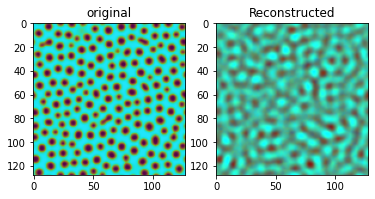

In [ ]:
img=X_test[np.random.choice(range(len(X_test)))]
print(img.shape)
print(img.max())

code= encoder.predict(img[None])[0]
reco = decoder.predict(code[None])[0]
plt.subplot(1,2,1)
plt.title("original")
show_image(img)
plt.subplot(1,2,2)
show_image(reco )
plt.title("Reconstructed")
plt.show()

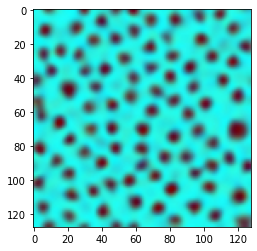

In [ ]:
show_image(denoise_image(denoise_image(reco )) )

# Prepare the encoded Dataset ===> 3D array (Samples x Sequence x Image_shape) ==> RNNs

In [ ]:
# remind that X is the dataset (normalized :/255 and centred :-0.5)
"""
X=X.reshape(dataset.shape)
encoded_data=[]
for i in range(dataset.shape[0]):   
    encoded_sequence=[]
    for j in range(dataset.shape[1]):
        img=X[i][j]
        encoded_frame= encoder.predict(img[None])[0]
        encoded_sequence.append(encoded_frame)

    encoded_data.append(encoded_sequence)
X_encoded=np.asarray(encoded_data)
print(X_encoded.shape)
"""
410.

(25, 100, 1000)


# Retrieving compressed dataset from file

In [ ]:
loaded_arr = np.loadtxt("encoded_data_7000_750.txt")  # you can start working on the code from this line if you don't have access to big computing resources
code_size=750
# This loadedArr is a 2D array, therefore
# we need to convert it to the original
# array shape.reshaping to get original
# array with original shape.
load_original_arr = loaded_arr.reshape(
loaded_arr.shape[0], loaded_arr.shape[1] // code_size, code_size) # X_encoded.shape[2], X_encoded.shape[2])

X_encoded=load_original_arr
print(X_encoded.shape)
X_1=X_encoded

(7332, 100, 750)


In [ ]:
"""
X_encoded_denoised=[]
for i in range(X_encoded.shape[0]):    
    encoded_sequence=[]
    for j in range(X_encoded.shape[1]):
        code=X_encoded[i][j]
        reco = decoder.predict(code[None])[0]
        encoded_frame= denoise_image(denoise_image(reco))
        encoded_sequence.append(encoded_frame)

    X_encoded_denoised.append(encoded_sequence)
X_encoded_denoised=np.asarray(X_encoded_denoised)
print(X_encoded_denoised.shape)
"""

In [4]:
# save X_encoded in an independent array (if needed)
X_encoded_save=X_encoded[:]
X_encoded_save=np.asarray(list(X_encoded))
print(X_encoded_save.shape)

(7332, 100, 750)


In [19]:
X_1=X_encoded_save  # X1 is the datest X transformed to the first latent dimension

#### reduced dataset (to be more homogenous)

In [7]:
import re
# https://python.hotexamples.com/fr/examples/features/-/get_features/python-get_features-function-examples.html
def get_features(str):
    array_str = re.findall("[-+]?[.]?[\d]+(?:,\d\d\d)*[\.]?\d*(?:[eE][-+]?\d+)?", str) 
    return np.array(array_str[:-1]).astype(float)


In [8]:
list_names=np.loadtxt ('list_names_7000.txt', dtype=str)  # remind : simulation characteristics
print(list_names.shape)

(7332, 100)


In [407]:
from numba import jit  # use to speed up python
# could be useful if choose to work with a subset from the global one (e.g. subset containg the set of simulations: (c<=0.65) and (m>=0.8) and (m<=1.25) and (k<=0.35))
def reduced_dataset(X_encoded,list_names):
    X_encoded_reduced=[]
    list_names_reduced=[]
    for i in range(X_encoded.shape[0]):    #
        encoded_sequence=[]
        features= get_features(list_names[i][0])
        c,m,k=features[0],features[1],features[2]
        #print(c,m,k)
        if (c<=0.65) and (m>=0.8) and (m<=1.25) and (k<=0.35):
           X_encoded_reduced.append(X_encoded[i])
           list_names_reduced.append(list_names[i])
    X_encoded_reduced=np.asarray(X_encoded_reduced)
    list_names_reduced=np.asarray(list_names_reduced)

    return  X_encoded_reduced,list_names_reduced


In [409]:
X_1,list_names_reduced=reduced_dataset(X_encoded,list_names)
print(X_1.shape)
print(list_names_reduced.shape)
X_encoded_reduced=X_1[:]
X_encoded_reduced=np.asarray(list(X_1))


(695, 100, 750)
(695, 100)


In [20]:
#X_encoded=X_encoded[:3500]
#X_encoded=X_encoded_save
#print(X_encoded.shape)
N=X_1.shape[0] # 3000 #X_encoded.shape[0]
#X_1=X_encoded[:N].reshape(np.prod(X_encoded[:N].shape[:2]),*X_encoded[:N].shape[2:])
X_1=X_1[:N].reshape(np.prod(X_1[:N].shape[:2]),*X_1[:N].shape[2:])
print(X_1.shape)  # X_1: to 2nd layer of encoder or PCA reduction 
#print(X_encoded_reduced.shape)

(733200, 750)


### To proceed with X_1 for second dimentionality reduction

## minor checks 

In [ ]:
code=X_1[np.random.choice(range(len(X_1)))]
print(code.max())
reco = decoder.predict(code[None])[0]

show_image(denoise_image(denoise_image(reco)))
plt.title("Reconstructed")
plt.show()
print(reco.min(), reco.max())



# Layer 2 ------------------ Encoder Decoder ------------------------------------------
---------------------------------------------------------------------------------------

In [283]:
from sklearn.model_selection import train_test_split
# the use of random_state is to reproduce the same results at each time 
X_1_train, X_1_test = train_test_split(X_1, test_size=0.1, random_state=42)
print(X_1_train.shape)
print(X_1_test.shape)


scaler= MinMaxScaler(feature_range=(0,1))



X_1_train_scaled=scaler.fit_transform(X_1_train)

X_1_test_scaled=scaler.transform(X_1_test)


# Re-Inspect the dataset.
print("Training Dataset Shapes: " + str(X_1_train_scaled.shape) + ", " + str(X_1_train_scaled.shape))
print("Validation Dataset Shapes: " + str(X_1_test_scaled.shape) + ", " + str(X_1_test_scaled.shape))

(62550, 750)
(6950, 750)
Training Dataset Shapes: (62550, 750), (62550, 750)
Validation Dataset Shapes: (6950, 750), (6950, 750)


In [ ]:
#X_1_train=X_1_train.reshape(np.prod(X_1_train.shape[:2]),*X_1_train.shape[2:])
#X_1_test = X_1_test.reshape(np.prod(X_1_test.shape[:2]),*X_1_test.shape[2:])

In [ ]:
# note that X_11 is the reshaped version of X_1
"""
X_11_train=X_1_train.reshape(np.prod(X_1_train.shape[:2]),*X_1_train.shape[2:])
X_11_test = X_1_test.reshape(np.prod(X_1_test.shape[:2]),*X_1_test.shape[2:])
X_11_train_scaled =X_1_train_scaled.reshape(np.prod(X_1_train_scaled.shape[:2]),*X_1_train_scaled.shape[2:])
X_11_test_scaled = X_1_test_scaled.reshape(np.prod(X_1_test_scaled.shape[:2]),*X_1_test_scaled.shape[2:])
"""

In [284]:
i =np.random.choice(range(len(X_1_train_scaled)), size=1)[0]
print('original:' ,'i= ',i, X_1_train[i].min(),X_1_train[i].max())
print('scaled: ','i= ',i, X_1_train_scaled[i].min(),X_1_train_scaled[i].max())

original: i=  17926 -5.500335216522217 4.139297008514404
scaled:  i=  17926 0.0 0.9407889437561023


#### Build the second auto-encoder

In [285]:
from keras.layers import Dense, Flatten, Reshape, Input, InputLayer
from keras.models import Sequential, Model

In [286]:
def build_autoencoder_2(img_shape, code_size):
    # The encoder
    encoder = Sequential()  
    encoder.add(InputLayer(img_shape))
    encoder.add(Dense(750))
    encoder.add(Dense(700))
    encoder.add(Dense(650))
    encoder.add(Dense(600))
    encoder.add(Dense(550))
    encoder.add(Dense(500))
    encoder.add(Dense(450))
    encoder.add(Dense(400))
    encoder.add(Dense(350))
    encoder.add(Dense(300))
    encoder.add(Dense(code_size))

    # The decoder
    decoder = Sequential()
    decoder.add(Dense(code_size))
    decoder.add(Dense(300))
    decoder.add(Dense(350))
    decoder.add(Dense(400))
    decoder.add(Dense(450))
    decoder.add(Dense(500))
    decoder.add(Dense(550))
    decoder.add(Dense(600))
    decoder.add(Dense(650))
    decoder.add(Dense(700))
    decoder.add(Dense(750))
    decoder.add(Dense(np.prod(img_shape))) 
    decoder.add(Reshape(img_shape))

    return encoder, decoder

In [288]:
Code_SHAPE =X_1.shape[1:] 

encoder_2, decoder_2 = build_autoencoder_2(Code_SHAPE, 200)

inp = Input(Code_SHAPE)
code = encoder_2(inp)
reconstruction = decoder_2(code)

autoencoder_2 = Model(inp,reconstruction)
autoencoder_2.compile(optimizer= 'adamax', loss='mse', metrics=['MSE'])  #binary_crossentropy
callbacks = [EarlyStopping(monitor='MSE', min_delta=0, patience=10)]
print(autoencoder_2.summary())

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 750)]             0         
_________________________________________________________________
sequential_8 (Sequential)    (None, 200)               3252950   
_________________________________________________________________
sequential_9 (Sequential)    (None, 750)               3293700   
Total params: 6,546,650
Trainable params: 6,546,650
Non-trainable params: 0
_________________________________________________________________
None


In [296]:
history = autoencoder_2.fit(X_1_train_scaled, X_1_train_scaled,
                epochs=100,
                batch_size=10                , 
                shuffle=True,
                validation_data=(X_1_test_scaled, X_1_test_scaled))  #callbacks=[model_checkpoint]

Epoch 1/100
6255/6255 [==============================] - 174s 28ms/step - loss: 0.0059 - MSE: 0.0059 - val_loss: 0.0060 - val_MSE: 0.0060
Epoch 2/100
6255/6255 [==============================] - 181s 29ms/step - loss: 0.0059 - MSE: 0.0059 - val_loss: 0.0058 - val_MSE: 0.0058
Epoch 3/100
6255/6255 [==============================] - 165s 26ms/step - loss: 0.0058 - MSE: 0.0058 - val_loss: 0.0058 - val_MSE: 0.0058
Epoch 4/100
6255/6255 [==============================] - 157s 25ms/step - loss: 0.0058 - MSE: 0.0058 - val_loss: 0.0059 - val_MSE: 0.0059
Epoch 5/100
6255/6255 [==============================] - 156s 25ms/step - loss: 0.0058 - MSE: 0.0058 - val_loss: 0.0058 - val_MSE: 0.0058
Epoch 6/100
6255/6255 [==============================] - 156s 25ms/step - loss: 0.0058 - MSE: 0.0058 - val_loss: 0.0058 - val_MSE: 0.0058
Epoch 7/100
6255/6255 [==============================] - 153s 24ms/step - loss: 0.0058 - MSE: 0.0058 - val_loss: 0.0058 - val_MSE: 0.0058
Epoch 8/100
6255/6255 [===========

In [ ]:
encoder_2.save('encoder_7000_750_250.h5')
decoder_2.save('decoder_7000_750_250.h5')


In [ ]:
from keras.models import load_model
save_dir=os.path.join(os.getcwd(), 'saved_computed_models\\')
 
#encoder_decoder = load_model(save_dir+model_name)
encoder_2= load_model(save_dir+'encoder_7000_750_250.h5')
decoder_2= load_model(save_dir+'decoder_7000_750_250.h5')


In [ ]:
X_encoded_reduced=X_encoded_save
print(X_encoded_reduced.shape)
print(X_encoded_save.shape)

(7332, 100, 750)
(7332, 100, 750)


In [ ]:
X_encoded_reduced=X_encoded

### Evaluate the second auto-encoder

In [ ]:
index1= np.random.choice(range(len(X_encoded_reduced)), size=1)[0]
index2= np.random.choice(range(X_encoded_reduced.shape[1]), size=1)[0]
print(index1,index2)

print(X_encoded_reduced.shape)

code_1=X_1.reshape(X_encoded_reduced.shape)[index1][index2]
print(code_1.shape)
# recode => original shape
img = decoder.predict(code_1[None])[0]

#plt.subplot(1,3,1)
"""
plt.title("original")
plt.imshow(dataset[index1][index2])
plt.axis('off')
plt.show()
#plt.subplot(1,3,2)
"""
show_image(denoise_image(denoise_image(img)))
plt.axis('off')
plt.title("Reconstructed -1 Layer")
plt.show()
print('original shape', img.shape)
print('code_1.shape', code_1.shape)
print('code_1.max',code_1.max())


code_2= encoder_2.predict(code_1[None])[0]
print('code_2.shape ',code_2.shape)
#code_2=scaler.inverse_transform(code_2.reshape(code_2.shape[0],1))
code_1_bis = decoder_2.predict(code_2[None])[0]
code_1_bis = decoder_2.predict(code_2[None])[0]
print('code_1_bis.shape ',code_1_bis.shape)


img_1=decoder.predict(code_1_bis[None])[0]

#plt.subplot(1,3,3)

img_1_denoised=denoise_image(denoise_image(img_1))
show_image(img_1_denoised )
plt.axis('off')
plt.title("Reconstructed -2 Layers")
print('img_1.shape ',img_1.shape)


plt.show()

## Encoded dataset 2

In [ ]:
"""
encoded_data_2=[]
X_1=X_1.reshape(X_encoded.shape)
for i in range(X_encoded.shape[0]):  
    encoded_sequence=[]
    for j in range(X_encoded.shape[1]):
        code=X_1[i][j]
        encoded_frame= encoder_2.predict(code[None])[0]
        encoded_sequence.append(encoded_frame)

    encoded_data_2.append(encoded_sequence)
X_encoded_2=np.asarray(encoded_data_2)
X_2=X_encoded_2
print(X_2.shape)
"""

'\nencoded_data_2=[]\nX_1=X_1.reshape(X_encoded.shape)\nfor i in range(X_encoded.shape[0]):  \n    encoded_sequence=[]\n    for j in range(X_encoded.shape[1]):\n        code=X_1[i][j]\n        encoded_frame= encoder_2.predict(code[None])[0]\n        encoded_sequence.append(encoded_frame)\n\n    encoded_data_2.append(encoded_sequence)\nX_encoded_2=np.asarray(encoded_data_2)\nX_2=X_encoded_2\nprint(X_2.shape)\n'

#### small test

In [ ]:
code_2=X_encoded_2[np.random.choice(range(X_encoded_2.shape[0]), size=1)[0]][np.random.choice(range(X_encoded_2.shape[1]), size=1)[0]]
print(code_2.shape)
code_1=decoder_2.predict(code_2[None])[0]
img=decoder.predict(code_1[None])[0]
show_image(denoise_image(denoise_image(img)) )


#### save your image in a .txt file

In [ ]:
a_file = open("c1_save.txt", "w")
for row in img_1_denoised[:, :, 0]:
    np.savetxt(a_file, row)

a_file.close()

## save the encoded data set in a txt file

In [ ]:
# reshaping the array from 3D
# matrice to 2D matrice.
X_2_reshaped = X_2.reshape(X_2.shape[0], -1)
  
# saving reshaped array to file.
np.savetxt("encoded_data_7000_500_250.txt", X_2_reshaped)

# Retrieving compressed data from file

In [ ]:
loaded_arr = np.loadtxt("encoded_data_7000_500_250.txt")  ## ==> RNNs 
code_size=250
# This loadedArr is a 2D array, therefore
# we need to convert it to the original
# array shape.reshaping to get original
# array with original shape.
load_original_arr = loaded_arr.reshape(
loaded_arr.shape[0], loaded_arr.shape[1] // code_size, code_size) # X_encoded.shape[2], X_encoded.shape[2])

X_encoded_2=load_original_arr
print(X_encoded_2.shape)
X_2=X_encoded_2

(7332, 100, 250)


# Principal Compoenent Analysis (PCA) dimensionality reduction --------------------------------------------------------

#### Scaling

In [35]:
import joblib
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer
PowerTransformer.inverse_transform

<function sklearn.preprocessing._data.PowerTransformer.inverse_transform(self, X)>

In [278]:
# first approach fo scaling : serial scaling
def get_normalized_array(data,scaler):
    m=data.shape[0]
    data_scaled=[]
    for i in range(m):  
        x=data[i]
        x = np.round(x,20)
        x=x.reshape(len(x), 1)
        #x_scaled=scaler.transform(x)
        scaler=scaler.fit(x.reshape(len(x), 1))
        scaler_filename = "scaler"+str(i)+".save"
        joblib.dump(scaler, os.path.join("scalers", scaler_filename)) 
        x_scaled=scaler.transform(x)
        x_scaled=np.squeeze(x_scaled, axis=1)
        x_scaled = np.round(x_scaled,20)
        data_scaled.append(x_scaled)
    return np.asarray(data_scaled)

In [279]:
# first approach fo inverse scaling : serial
def get_rescaled_array(data):
    m=data.shape[0]
    data_rescaled=[]
    for i in range(m):  
        x=data[i]
        x = np.round(x,20)
        x = x.reshape(len(x), 1)
        scaler_filename = "scaler"+str(i)+".save"
        scaler = joblib.load(os.path.join("scalers", scaler_filename)) 
        x_rescaled=scaler.inverse_transform(x)
        x_rescaled=np.squeeze(x_rescaled, axis=1)
        x_rescaled = np.round(x_rescaled,20)
        data_rescaled.append(x_rescaled)
    return np.asarray(data_rescaled)

#### Scaling

In [392]:
scaler=MinMaxScaler(feature_range=(-1,1)) #StandardScaler()    # StandardScaler() #

In [393]:
"""
Choose which scaling method you want to try 

from sklearn.preprocessing import scale,StandardScaler,minmax_scale
from sklearn.decomposition import FastICA
#scaler= MinMaxScaler(feature_range=(0,1)) 
scaler= StandardScaler()
#scaler=PowerTransformer(method='yeo-johnson', standardize=True)
#scaler=RobustScaler()
#scaler=minmax_scale()


scaler = scaler.fit(X_1)
X_1_scaled = scaler.fit_transform(X_1)

#X_1_scaled=(X_1 - X_1.min())/(X_1.max() - X_1.min())
#X_1_scaled,scaler=get_normalized_array(X_1,scaler)                                                      
                                                      
print(X_1_scaled.shape) 
"""
X_1_scaled=get_normalized_array(X_1[:],scaler) 

X_1_scaled = scaler.fit_transform(X_1)
print(X_1_scaled.min(),X_1_scaled.max())

-1.0 1.0000000000000002


#### Re-Scaling

In [394]:
X_1_rescaled=get_rescaled_array(X_1_scaled)
                           
#X_1_rescaled= scaler.inverse_transform(X_1_scaled)
#X_1_rescaled=  (X_1.max() - X_1.min())*X_1_scaled+X_1.min()


#### Checks (shapes)

In [395]:
print('X_1.shape :',X_1.shape,'X_1_scaled.shape :',X_1_scaled.shape,' X_1_rescaled.shape: ' ,X_1_rescaled.shape)
print(X_1[:].min(),X_1[:].max())
print(X_1_scaled.min(),X_1_scaled.max())
print(X_1_rescaled.min(),X_1_rescaled.max())

X_1.shape : (733200, 750) X_1_scaled.shape : (733200, 750)  X_1_rescaled.shape:  (733200, 750)
-23.208711624145508 13.33464241027832
-1.0 1.0000000000000002
-23.208711624145508 13.334642410278319


#### PCA decomposition

In [396]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
pca = PCA(n_components=250 ) # 
X_1_pca=pca.fit_transform(X_1_scaled[:])   # X_1_scaled[:]

print(X_1_pca.shape) 


(733200, 250)


#### data visualization ==> could be useful to see how biased is the dataset for example

(array([[   0.,    0.,    0., ...,  325.,    0.,    0.],
        [   0.,    0.,    0., ...,  255.,    0.,    0.],
        [   0.,    0.,    0., ...,  289.,    0.,    0.],
        ...,
        [   0.,    0.,    0., ..., 1106.,    2.,    0.],
        [   0.,    0.,    0., ...,  593.,    0.,    0.],
        [   0.,    0.,    0., ...,  434.,    0.,    0.]]),
 array([-22.58154678, -19.02999048, -15.47843418, -11.92687788,
         -8.37532158,  -4.82376528,  -1.27220898,   2.27934732,
          5.83090363,   9.38245993,  12.93401623]),
 <a list of 750 BarContainer objects>)

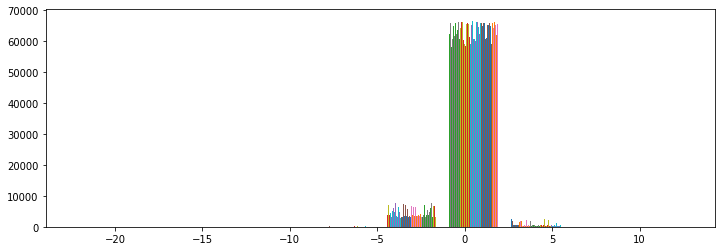

In [332]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.hist(X_1[:,])  

(array([ 83461., 127019.,  78904.,  54384.,  44193.,  52262.,  47783.,
         58298.,  92524.,  94372.]),
 array([-1.72747083, -1.36957522, -1.0116796 , -0.65378399, -0.29588837,
         0.06200725,  0.41990286,  0.77779848,  1.13569409,  1.49358971,
         1.85148533]),
 <BarContainer object of 10 artists>)

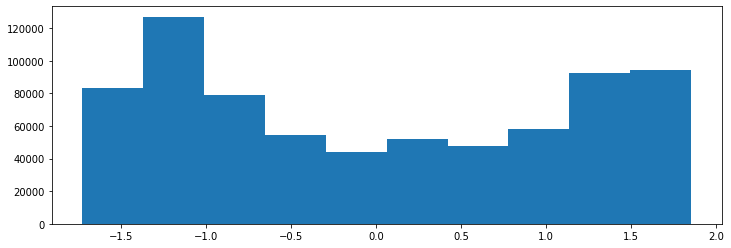

In [397]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.hist(X_1_pca[:,0]) 

## Explained variance

In [ ]:
plt.grid()
plt.xlabel('Number of components')
plt.ylabel('Explained variance')
plt.plot(np.cumsum(pca. explained_variance_ratio_ * 100))

### Recovering and rescaling

In [400]:
X_1_pca_recov_scaled=pca.inverse_transform(X_1_pca)
#X_1_pca_recov=scaler.inverse_transform(X_1_pca_recov_scaled)

In [401]:
X_1_pca_recov=get_rescaled_array(X_1_pca_recov_scaled)
#X_1_pca_recov=scaler.inverse_transform(X_1_pca_recov_scaled)

In [402]:
print(X_1[:].shape, X_1[:].min(),X_1[:].max())
print(X_1_pca.shape,X_1_pca.min(),X_1_pca.max())
print(X_1_pca_recov.shape, X_1_pca_recov.min(),X_1_pca_recov.max())

(733200, 750) -23.208711624145508 13.33464241027832
(733200, 250) -1.914188665002143 2.1047205898593764
(733200, 750) -23.569156270885617 13.805372989824011


## sensitivity analysis

### Predictions using PCA

In [ ]:
index_1= np.random.choice(range(len(X_encoded_reduced[:N])), size=1)[0]
index_2= np.random.choice(range(X_encoded_reduced[:N].shape[1]), size=1)[0]


print('(index 1,index 2): ',index_1,index_2)

code_1=X_1.reshape(X_encoded_reduced[:N].shape)[index_1][index_2]
print('code_1.shape',code_1.shape)
# recode => original shape
img = decoder.predict(code_1[None])[0]
"""
#plt.subplot(1,3,1)
plt.title("original")
plt.imshow(dataset[index_1][index_2])
plt.axis('off')
plt.show()
#plt.subplot(1,3,2)
"""

show_image(denoise_image(denoise_image(img)))
plt.axis('off')
plt.title("Reconstructed -1 Layer")
plt.show()
print('original shape', img.shape)
print('code_1.shape', code_1.shape)
print('code_1.max',code_1.max())
print('X_1_pca.shape',X_1_pca.shape)


"""
code_2=pca.transform(code_1.reshape(code_1.shape[0], 1))[1]
scaler_filename = "scaler"+str(index_2)+".save"
scaler = joblib.load(os.path.join("scalers", scaler_filename)) 
code_2=code_2.reshape(code_2.shape[0], 1)
code_2=scaler.inverse_transform(code_2)
code_2=np.squeeze(code_2, axis=1)
"""

#code_2= X_1_pca.reshape(X_encoded.shape[0],X_encoded.shape[1] ,X_1_pca.shape[1])[index_1][index_2]  # code 2 will be used in LSTM 


#print('code_2.shape',code_2.shape)


#code_1_recov=pca.inverse_transform(code_2) # 

code_1_recov=X_1_pca_recov.reshape(X_encoded_reduced[:N].shape)[index_1][index_2]

#print('code_1_recov.shape before rescale: ',code_1_recov.shape)

#print('code_1_recov.max() before rescale: ',code_1_recov.max())


#code_1_recov=code_1_recov.reshape(code_1_recov.shape[0], 1)
# scaler = scaler.fit(code_1_recov) 
#scaler=scaler.fit(X_1[-1].reshape(len(X_1[-1]), 1))
#code_1_recov=scaler.inverse_transform(code_1_recov)                           
#code_1_recov=np.squeeze(code_1_recov, axis=1)



print('code_1_recov.max() : ',code_1_recov.max())


img_1=decoder.predict(code_1_recov[None])[0]
img_1[np.where(img_1 <= 1e-30)]=0.000005  

#plt.subplot(1,3,3)

img_1_denoised=denoise_image(denoise_image(img_1))
show_image(img_1)
plt.axis('off')
plt.title("Reconstructed -2 Layers")
print('img_1.shape ',img_1.shape)


plt.show()

### save X_1_pca in a text file as well as X_1_pca_recov

In [ ]:
np.savetxt('X_1_pca.txt',X_1_pca)

In [ ]:
X_1_pca=np.loadtxt('X_1_pca.txt')
X_1_pca.shape

(733200, 250)

# LSTM model --------------------------------------------------------------------------------------------

Some line codes and function are copied or inspired from
https://keras.io/examples/vision/conv_lstm/

https://www.kaggle.com/code/drscarlat/next-frame-video-prediction-keras/notebook

## Prepare the new data : each image is represented by : 
### the main features of the simulation: concentration, mobililty , gradient coefficient
### the encoded array 

In [80]:
X_2=X_1_pca.reshape(X_encoded[:N].shape[0],X_encoded[:N].shape[1] ,X_1_pca.shape[1])
print(X_2.shape)

(7332, 100, 250)


In [ ]:
X_new= X2

## Split Data into Train and Validation datasets

In [128]:
# We'll define a helper function to shift the frames, where
# `x` is frames 0 to n - 1, and `y` is frames 1 to n.

def create_shifted_frames(data,N_output):
    x = data[:, 0 : data.shape[1] - N_output, :]   #data[:, 0 : data.shape[1] - 1, :]
    y =   data[:, data.shape[1]-N_output : data.shape[1], :]      #data[:, 1 : data.shape[1], :]
    return x, y

In [129]:
indexes = np.arange(X_new.shape[0])  #(
np.random.shuffle(indexes)
train_index = indexes[: int(0.9 * X_new.shape[0])] #X_encoded.shape[0]
val_index = indexes[int(0.9 * X_new.shape[0]) :]  
train_dataset = X_new[train_index]
val_dataset = X_new[val_index]

N_outputs=5   # predict the last N frames

# Apply the processing function to the datasets.
x_train, y_train = create_shifted_frames(train_dataset[:, 0:train_dataset.shape[1]:1],N_outputs)  #train_dataset.shape[1]:4
x_val, y_val = create_shifted_frames(val_dataset[:, 0:val_dataset.shape[1]:1],N_outputs)  #val_dataset.shape[1]:4

# Inspect the dataset.
print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))


Training Dataset Shapes: (6598, 95, 253), (6598, 5, 253)
Validation Dataset Shapes: (734, 95, 253), (734, 5, 253)


# Normalize data

In [ ]:
# a first way to normaize data 
def get_normalized_data(array_data,scaler):
    
    x_train_scaled,y_train_scaled,x_val_scaled,y_val_scaled=[],[],[],[]
    dummy=[]
    for idx in range(len(array_data)):
        m=np.asarray(array_data[idx]).shape[0]
        n=np.asarray(array_data[idx]).shape[1]
        data=[]
        for i in range(m):  
            sequence=[] 
            for j in range(n):
                x=array_data[idx][i][j]
                x = x.reshape(len(x), 1)
                scaler = scaler.fit(x)
                x_scaled=scaler.transform(x)
                x_scaled=np.squeeze(x_scaled, axis=1)
                sequence.append(x_scaled)
            data.append(sequence)
        dummy.append(data)
    x_train_scaled,y_train_scaled,x_val_scaled,y_val_scaled=np.asarray(dummy[0]),np.asarray(dummy[1]),\
        np.asarray(dummy[2]),np.asarray(dummy[3])
    return  x_train_scaled,y_train_scaled,x_val_scaled,y_val_scaled


In [130]:
import numpy as np
from sklearn.base import TransformerMixin
from sklearn.preprocessing import StandardScaler

# more robsut way for normalization 
# https://pyquestions.com/how-to-standard-scale-a-3d-matrix
class NDStandardScaler(TransformerMixin):
    def __init__(self, **kwargs):
        self._scaler = MinMaxScaler(feature_range=(0,1)) # StandardScaler() #
        self._orig_shape = None

    def fit(self, X, **kwargs):
        X = np.array(X)
        # Save the original shape to reshape the flattened X later
        # back to its original shape
        if len(X.shape) > 1:
            self._orig_shape = X.shape[1:]
        X = self._flatten(X)
        self._scaler.fit(X, **kwargs)
        return self

    def transform(self, X, **kwargs):
        X = np.array(X)
        X = self._flatten(X)
        X = self._scaler.transform(X, **kwargs)
        X = self._reshape(X)
        return X

    def inverse_transform(self, X, **kwargs):
        X = np.array(X)
        X = self._flatten(X)
        X = self._scaler.inverse_transform(X, **kwargs)
        X = self._reshape(X)
        return X

    def _flatten(self, X):
        # Reshape X to <= 2 dimensions
        if len(X.shape) > 2:
            n_dims = np.prod(self._orig_shape)
            X = X.reshape(-1, n_dims)
        return X

    def _reshape(self, X):
        # Reshape X back to it's original shape
        if len(X.shape) >= 2:
            X = X.reshape(-1, *self._orig_shape)
        return X

In [ ]:
scaler_ND = NDStandardScaler()
array_data=[x_train,y_train,x_val,y_val ]  

#x_train_scaled,y_train_scaled,x_val_scaled,y_val_scaled=get_normalized_data(array_data,scaler)

print(x_train.shape,x_val.shape,y_train.shape,y_val.shape)
x_train_scaled = scaler_ND.fit_transform(x_train)
print(x_train_scaled.min(),x_train_scaled.max())
x_val_scaled = scaler_ND .transform(x_val)
y_train_scaled = scaler_ND.fit_transform(y_train)
print(y_train_scaled.min(),y_train_scaled.max())
y_val_scaled = scaler_ND.transform(y_val)



# Re-Inspect the dataset.
print("Training Dataset Shapes: " + str(x_train_scaled.shape) + ", " + str(y_train_scaled.shape))
print("Validation Dataset Shapes: " + str(x_val_scaled.shape) + ", " + str(y_val_scaled.shape))

## minor checks

In [132]:
i =np.random.choice(range(len(y_train_scaled)), size=1)[0] 
j=np.random.choice(range(y_train_scaled.shape[1]), size=1)[0]
print('original:' ,'i= ',i,' j= ',j,' min: ',y_train[i][j].min(),' max: ',y_train[i][j].max())
print('scaled: ','i= ',i,' j= ',j,' min: ',y_train_scaled[i][j].min(),' max: ',y_train_scaled[i][j].max())

original: i=  4091  j=  2  min:  -1.027309432300245  max:  1.1
scaled:  i=  4091  j=  2  min:  0.04513166182169104  max:  0.9704315636753037


## Model architecture (LSTM or GRU : the same)

In [387]:
from keras.models import Sequential
from keras.layers import LSTM, Dense  , RepeatVector, TimeDistributed
from keras.layers.core import Dense, Activation, Dense, Dropout

N_INPUTS=x_train_scaled.shape[1]
N_OUTPUTS=y_val_scaled.shape[1]
N_FEATURES=X_new.shape[2]
N_BLOCKS=500


model = Sequential()
model.add(LSTM(N_BLOCKS, input_shape=(N_INPUTS, N_FEATURES) ))  
model.add(RepeatVector(N_OUTPUTS))

model.add(LSTM(N_BLOCKS, return_sequences=True)) 



model.add(layers.LSTM(N_BLOCKS, return_sequences=True))
model.add(layers.LSTM(N_BLOCKS, return_sequences=True))

model.add(layers.LSTM(N_BLOCKS, return_sequences=True))
model.add(layers.LSTM(N_BLOCKS, return_sequences=True))



"""
model.add(layers.Dropout(0.2))

model.add(layers.LSTM(N_BLOCKS, return_sequences=True))
model.add(layers.Dropout(0.2))

model.add(layers.LSTM(N_BLOCKS, return_sequences=True))
model.add(layers.Dropout(0.2))
"""

model.add(Dense(N_FEATURES))
#model.add(Activation('linear'))
model.compile(loss='mse', optimizer='adamax')
model.summary()



Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 500)               1508000   
_________________________________________________________________
repeat_vector_4 (RepeatVecto (None, 5, 500)            0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 5, 500)            2002000   
_________________________________________________________________
module_wrapper_22 (ModuleWra (None, 5, 500)            2002000   
_________________________________________________________________
module_wrapper_23 (ModuleWra (None, 5, 500)            2002000   
_________________________________________________________________
module_wrapper_24 (ModuleWra (None, 5, 500)            2002000   
_________________________________________________________________
module_wrapper_25 (ModuleWra (None, 5, 500)           

In [388]:
from keras.callbacks import EarlyStopping 
earlyStop = EarlyStopping(monitor="val_loss",verbose=2,mode='min',patience=10)
model_checkpoint=tf.keras.callbacks.ModelCheckpoint('CIFAR10{epoch:02d}.h5',save_freq=2,save_weights_only=False)
history=model.fit(x_train_scaled, y_train_scaled,
          batch_size=32, epochs=20,
          validation_data=(x_val_scaled, y_val_scaled), callbacks=earlyStop)


Epoch 1/20
207/207 [==============================] - 153s 689ms/step - loss: 0.0486 - val_loss: 0.0102
Epoch 2/20
207/207 [==============================] - 139s 671ms/step - loss: 0.0106 - val_loss: 0.0101
Epoch 3/20
207/207 [==============================] - 140s 676ms/step - loss: 0.0108 - val_loss: 0.0101
Epoch 4/20
207/207 [==============================] - 127s 614ms/step - loss: 0.0107 - val_loss: 0.0102
Epoch 5/20
207/207 [==============================] - 130s 627ms/step - loss: 0.0107 - val_loss: 0.0102
Epoch 6/20
207/207 [==============================] - 123s 594ms/step - loss: 0.0106 - val_loss: 0.0101
Epoch 7/20
207/207 [==============================] - 121s 587ms/step - loss: 0.0105 - val_loss: 0.0102
Epoch 8/20
207/207 [==============================] - 119s 576ms/step - loss: 0.0108 - val_loss: 0.0102
Epoch 9/20
207/207 [==============================] - 130s 629ms/step - loss: 0.0106 - val_loss: 0.0102
Epoch 10/20
207/207 [==============================] - 133s 641m

##show loss

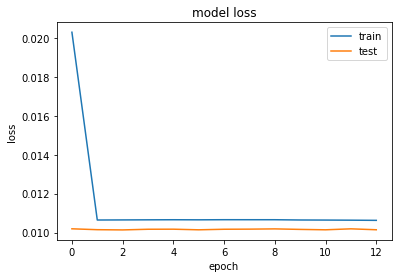

In [389]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()


## save the model

In [ ]:
lstm_model_name='lstm_7000_750_pca_250_81epoch.h5'  # 7000 samples ,  750: laten dim 1  , 250 : latent dim 2 , epochs for training : 81 
model.save(lstm_model_name)
#model.save(os.path.join(save_dir,lstm_model_name))

### load the saved model

In [ ]:
model=load_model(os.path.join(save_dir,lstm_model_name))


# make predictions

In [339]:
index= np.random.choice(range(len(x_val_scaled)), size=1)[0]
print('sample n° :',index, 'from the validate dataset')


example =x_val_scaled[index] 
print('example.shape : ',example.shape)
actual_frames=example[:N_INPUTS, ...]
print('shape of frames to predict: ',actual_frames.shape)

new_prediction = model.predict(np.expand_dims(actual_frames, axis=0))
new_prediction = np.squeeze(new_prediction, axis=0)
print('new_prediction.shape: ',new_prediction.shape)

sequence = np.concatenate((actual_frames, new_prediction), axis=0)
print('"original_frames+prediction" shape ',sequence .shape)

print('actual_frames.shape',actual_frames.shape,actual_frames[0].shape)
print('min,max',actual_frames[0].min(),actual_frames[0].max())

print('new_prediction.shape',new_prediction.shape,new_prediction[0].shape)
print('min,max',new_prediction[0].min(),new_prediction[0].max())
#new_prediction=new_prediction[::, 3:new_prediction.shape[1]]  # uncomment if characteristics are not considered
print('new_prediction.shape',new_prediction.shape)
"""
from sklearn.metrics import mean_squared_error, r2_score
index_1=np.random.choice(range(len(y_val_scaled[::, ::,3:y_val.shape[2]])), size=1)[0]
y_actual= y_val_scaled[::, ::,3:y_val.shape[2]][index_1]
y_predicted=new_prediction
rms = mean_squared_error(y_actual, y_predicted, squared=False)
r2=r2_score(y_actual[0], y_predicted[0])
print('r2 :', r2, ' RMSE: ',rms )
"""


sample n° : 579 from the validate dataset
example.shape :  (95, 253)
shape of frames to predict:  (95, 253)
new_prediction.shape:  (5, 253)
"original_frames+prediction" shape  (100, 253)
actual_frames.shape (95, 253) (253,)
min,max 0.03556372155356591 0.8323491425305769
new_prediction.shape (5, 253) (253,)
min,max 0.23390578 0.5867462
new_prediction.shape (5, 253)


"\nfrom sklearn.metrics import mean_squared_error, r2_score\nindex_1=np.random.choice(range(len(y_val_scaled[::, ::,3:y_val.shape[2]])), size=1)[0]\ny_actual= y_val_scaled[::, ::,3:y_val.shape[2]][index_1]\ny_predicted=new_prediction\nrms = mean_squared_error(y_actual, y_predicted, squared=False)\nr2=r2_score(y_actual[0], y_predicted[0])\nprint('r2 :', r2, ' RMSE: ',rms )\n"

## plot predictions  (for small sequence)

In [340]:
#y_val=y_val[::, ::,3:y_val.shape[2]]
print(y_val.shape)
print(y_val.reshape(np.prod(y_val.shape[:2]),*y_val.shape[2:]).shape)

(734, 5, 250)
(3670, 250)


#### y_val_rescaled ;  the shape of the code (auto-encoder)

In [341]:
y_val_recovered_scaled=pca.inverse_transform(y_val.reshape(np.prod(y_val.shape[:2]),*y_val.shape[2:]))
print(y_val_recovered_scaled.shape)

(3670, 750)


In [342]:
# reshape y_val_rescaled
print(y_val.shape)
origninal_shape=(y_val.shape[0],y_val.shape[1],y_val_recovered.shape[-1])

#y_val_recovered=get_rescaled_array(y_val_recovered).reshape(origninal_shape)
y_val_recovered=scaler.inverse_transform(y_val_recovered_scaled)  #)
y_val_recovered=y_val_recovered.reshape(origninal_shape)
print(y_val_recovered.shape)


(734, 5, 250)
(734, 5, 750)


#### new_prediction_rescaled => the shape of the code (auto-encoder)

In [343]:
print(new_prediction.shape)
#new_prediction_recovered=get_rescaled_array(pca.inverse_transform(new_prediction))
new_prediction_recovered=scaler.inverse_transform(pca.inverse_transform(new_prediction[::,3:new_prediction.shape[1]]))
print(new_prediction_recovered.shape)

(5, 253)
(5, 750)


In [ ]:
#encoded_original_frames=y_val[index]

#  original last n frames (to predict)
encoded_original_frames= y_val_recovered[index] #[::, ::,3:y_val.shape[2]][index]  : use this in the first time to delete simulation characteristics : 253 ==> 250


# Construct a figure for the original and new frames.
fig, axes = plt.subplots(2, 5, figsize=(20, 4))

# original frames
for idx, ax in enumerate(axes[0]):
    code=encoded_original_frames[idx]
    #print(code.shape)
    img=decoder.predict(code[None])[0]
    ax.imshow(np.clip(img + 0.5, 0, 1))
    ax.set_title(f"Frame {idx + N_INPUTS+1}")
    ax.axis("off")
    

# prediction
for idx, ax in enumerate(axes[1]):
    code=new_prediction_recovered[idx]
    #print(code.min(),code.max())
    #print(code.shape)
    #encoded_scaled_frame = code.reshape(encoded_scaled_frame.shape[0], 1)
    #frame_inverted=scaler.inverse_transform(encoded_scaled_frame)   # you should use the same
    #frame_inverted=np.squeeze(frame_inverted, axis=1)

    img=decoder.predict(code[None])[0]
    ax.imshow(np.clip(img+0.5, 0, 1))
    #ax.imshow(frame)
    ax.set_title(f"Frame {idx + N_INPUTS+1}") 
    ax.axis("off")
plt.savefig('predictions')

## return MSE, r2

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
index_1=np.random.choice(range(len(y_val_scaled[::, ::,3:y_val.shape[2]])), size=1)[0]
y_actual= y_val_scaled[::, ::,3:y_val.shape[2]][index_1]
y_predicted=new_prediction
rms = mean_squared_error(y_actual, y_predicted, squared=False)
r2=r2_score(y_actual[0], y_predicted[0])
print('r2 :', r2, ' RMSE: ',rms )

In [ ]:
a_file = open("c0_save.txt", "w")
for row in denoise_image(denoise_image(img))[:, :, 0]:  #
    np.savetxt(a_file, row)

a_file.close()

### LSTM/GRU

In [35]:
loss_lstm_gru=np.loadtxt('loss_lstm_gru.txt')  # load saved losses
loss_lstm=loss_lstm_gru[:,0]
val_loss_lstm=loss_lstm_gru[:,1]
loss_gru=loss_lstm_gru[:,2]
val_loss_gru=loss_lstm_gru[:,3]

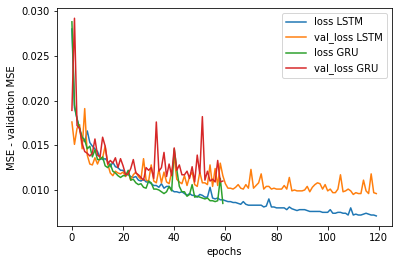

In [36]:
plt.plot(loss_lstm[:120],label='loss LSTM')
plt.plot(val_loss_lstm[:120],label='val_loss LSTM')
plt.plot(loss_gru[:60],label='loss GRU')
plt.plot(val_loss_gru[:60],label='val_loss GRU')
plt.xlabel('epochs')
plt.ylabel('MSE - validation MSE')
plt.legend()